data was scrapped on june 13 2020

To Do:
* add support for Airbnb listing accommodations (wifi, A/C, etc.)
* description of process/results


In [66]:
#Import Libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedShuffleSplit, KFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
import operator
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
random_state=13

## Import and Cleaning

In [ ]:
calendar = pd.read_csv('D:/Desktop/Datasets/AirbnbBerlin/calendar.csv.gz');
listings1 = pd.read_csv('D:/Desktop/Datasets/AirbnbBerlin/listings.csv');
listings2 = pd.read_csv('D:/Desktop/Datasets/AirbnbBerlin/listings.csv.gz');
neighborhoods = pd.read_csv('D:/Desktop/Datasets/AirbnbBerlin/neighbourhoods.csv');
reviews1 = pd.read_csv('D:/Desktop/Datasets/AirbnbBerlin/reviews.csv');
reviews2 = pd.read_csv('D:/Desktop/Datasets/AirbnbBerlin/reviews.csv.gz');

#Data Notes:

#locations are not exact (0-450 feet from actual address) due to how airbnb displays data. Therefore a heatmap will work well
#price is in dollars

Start by fixing the data types for each table

In [3]:
#Data cleaning functions used below

#I would prefer integers to have no trailing zeros

#This function will search a specifc dataframe column and return the number of non integer values and NAN values
#I am doing this because I want to keep the trailing zeros if there are values in the array 
#I wont be able to take away trailing zeros if there are any nan values
def find_noninteger(Dataframe,feature): #feature should be input as a string to be consistent with normal pandas format
    value=Dataframe[feature];
    float_count=0;na_count=0;index_nonint=[];index_na=[];
    for i in range(len(value)):
        if (value[i]).is_integer()==0 | pd.isna(value[i])==0:
            float_count +=1
            index_nonint.append(i)
        if pd.isna(value[i])==1:
            na_count +=1
            #index_na.append(i)
    if float_count==1 and na_count==1:
        print('There is',float_count,'non integer value and',na_count,'NAN value')
    elif float_count==1 and na_count!=1:
        print('There is',float_count,'non integer value and',na_count,'NAN values')
    elif float_count!=1 and na_count==1:
        print('There are',float_count,'non integer values and',na_count,'NAN value')
    elif float_count!=1 and na_count!=1:
        print('There are',float_count,'non integer values and',na_count,'NAN values')
    if index_nonint or index_na:
        print('The non integer values are located at:',index_nonint)

### Calendar Data Table
    The calendar table holds availibility data for every listing. The availibility is given from
    the date sampled up to one full year. Therefore, each listing will have 365 sample points.

In [4]:
calendar.head(n=5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,80843,2020-06-14,f,$39.00,$39.00,2.0,1125.0
1,186851,2020-06-15,f,$33.00,$33.00,62.0,300.0
2,186851,2020-06-16,f,$33.00,$33.00,62.0,300.0
3,186851,2020-06-17,f,$33.00,$33.00,62.0,300.0
4,186851,2020-06-18,f,$33.00,$33.00,62.0,300.0


In [5]:
#Missing Values
calendar_missingvalues_df=calendar[calendar.isna().any(axis=1)]    #dataframe containing only rows with any missing values
calendar_missingvalues_columns=calendar.columns[calendar.isna().any()].tolist()  #list of columns with missing values
print('These features have missing values:',calendar_missingvalues_columns)
print('\'minimum_nights\' has',calendar['minimum_nights'].isna().sum(),'missing values')
print('\'maximum_nights\' has',calendar['maximum_nights'].isna().sum(),'missing values')

# 'minimumn_nights' and 'maximum_nights':

#I have found that these 141 missing values are all from different listings, and they all
#occur on the sample date. This is just a data collection error
#I can pull the min and max nights values from other entries since they will be the same for the listing 

#pull the listing_id for the missing value, set missing values to be the same as the following row in full df
#use the sub table to reduce cpu load
for i in range(len(calendar_missingvalues_df)):
    missing_listing_id=calendar_missingvalues_df.iloc[i]['listing_id']
    missing_index=calendar_missingvalues_df.index[calendar_missingvalues_df['listing_id']==missing_listing_id].values[0]
    missing_listing_df=calendar.loc[calendar['listing_id']==missing_listing_id]
    
    calendar.at[missing_index,'minimum_nights']=missing_listing_df.iloc[50]['minimum_nights']  #choose arbitrary future date to set these values to
    calendar.at[missing_index,'maximum_nights']=missing_listing_df.iloc[50]['maximum_nights']
    
print('After filling missing values with the correct values:')
print('\'minimum_nights\' has',calendar['minimum_nights'].isna().sum(),'missing values')
print('\'maximum_nights\' has',calendar['maximum_nights'].isna().sum(),'missing values')


These features have missing values: ['minimum_nights', 'maximum_nights']
'minimum_nights' has 141 missing values
'maximum_nights' has 141 missing values
After filling missing values with the correct values:
'minimum_nights' has 0 missing values
'maximum_nights' has 0 missing values


In [6]:
#check columns for decimal values. This will indicated whether or not I should remove trailing zeros (by converting to INT)
print('minimum nights:')
#find_noninteger(calendar,'minimum_nights')
print('maximum nights:')
#find_noninteger(calendar,'maximum_nights')
print('-'*50);print('Before:');print(calendar.dtypes)  #This indicates, that once I deal with missing values I can convert these cols to int


#Convert Data Types
#convert to datetime
calendar['date']=calendar['date'].astype('datetime64')
#convert to boolean
bool_map={'t':True,'f':False}
calendar['available']=calendar['available'].map(bool_map).astype('bool')
#remove dollar signs, remove comas, and convert to float
calendar['price']=calendar['price'].str.replace('$','').str.replace(',','').astype('float64') 
calendar['adjusted_price']=calendar['adjusted_price'].str.replace('$','').str.replace(',','').astype('float64')
#Convert to INT (no decimal place values and no more missing values)
calendar['minimum_nights']=calendar['minimum_nights'].astype(int)
calendar['maximum_nights']=calendar['maximum_nights'].astype(int)
print('-'*50);print('After:')
print(calendar.dtypes)


minimum nights:
maximum nights:
--------------------------------------------------
Before:
listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object
--------------------------------------------------
After:
listing_id                 int64
date              datetime64[ns]
available                   bool
price                    float64
adjusted_price           float64
minimum_nights             int32
maximum_nights             int32
dtype: object


In [7]:
calendar.head()

#number of observations in df
#number of unique listings

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,80843,2020-06-14,False,39.0,39.0,2,1125
1,186851,2020-06-15,False,33.0,33.0,62,300
2,186851,2020-06-16,False,33.0,33.0,62,300
3,186851,2020-06-17,False,33.0,33.0,62,300
4,186851,2020-06-18,False,33.0,33.0,62,300


### Listings Data Table

##### Listings_1 Data Table
    This table provides a summary of every available listing with basic, important information

In [8]:
listings1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ion,Mitte,Brunnenstr. Süd,52.53454,13.40256,Entire home/apt,60,4,132,2020-04-03,2.59,7,180
1,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53500,13.41758,Entire home/apt,90,62,146,2020-05-27,1.09,1,0
2,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.49885,13.34906,Private room,28,7,27,2019-05-31,0.32,1,364
3,7071,BrightRoom with sunny greenview!,17391,BrightRoom,Pankow,Helmholtzplatz,52.54316,13.41509,Private room,33,1,293,2020-03-31,2.22,2,61
4,9991,Geourgeous flat - outstanding views,33852,Philipp,Pankow,Prenzlauer Berg Südwest,52.53303,13.41605,Entire home/apt,180,6,8,2020-01-04,0.14,1,10


In [9]:
#change col name id to listing_id
listings1.rename(columns={'id':'listing_id','neighbourhood':'neighborhood'},inplace=True)
#remove 'neighbourhood_group' this is already shown in neighborhood table, also remove last_review since I don't care when a listing was last_reviewed
listings1.drop(['neighbourhood_group','last_review'],axis=1,inplace=True)

print(listings1.dtypes)

listing_id                          int64
name                               object
host_id                             int64
host_name                          object
neighborhood                       object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


In [10]:
print('This table includes basic listing infromation for',listings1.shape[0],'Airbnbs')

This table includes basic listing infromation for 24813 Airbnbs


##### Listings_2 Data Table
    This table provides a much more indepth version of Listings_1. This table includes 106 columns, many of them will not be used.
    I will take out columns that i feel will have no impact on the price of the apartment or that will be useful to see in visualizations.
    Some examples of things I will remove are urls,repeated info,and unneeded ID info.
    I will also remove information which is already shown in Listings_1 since I don't need the repeated information. However, 'listing_id' will
    be left there since it is acting as my primary key
    
    I will use this table when I want more information for a listing which Listings_1 doesn't provide

In [11]:
#listings2.head()

In [12]:
experiences_offered=listings2.loc[listings2['experiences_offered']!='none']
print(len(experiences_offered),'Airbnbs offer and additional experience')   #therfore will remove this col

listings2.rename(columns={'id':'listing_id','neighbourhood':'neighborhood'},inplace=True)
listings2.drop(['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_location','host_about','host_thumbnail_url','host_picture_url',
                'host_neighbourhood','host_has_profile_pic','city','state','zipcode','market','smart_location','country_code','country','is_location_exact','minimum_minimum_nights','maximum_minimum_nights',
                'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_last_scraped','number_of_reviews_ltm','first_review','last_review','review_scores_accuracy',
                'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','requires_license','license','jurisdiction_names',
                'require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                'street','neighbourhood_cleansed','host_total_listings_count','is_business_travel_ready','host_verifications','host_since','listing_url',
                'host_id','host_listings_count','host_identity_verified','neighborhood','latitude','longitude','room_type', 'price', 'minimum_nights','last_review','reviews_per_month','number_of_reviews',
                'calculated_host_listings_count'],axis=1,inplace=True)
print(listings2.columns.values)
#I have left only what I think may be useful

0 Airbnbs offer and additional experience
['listing_id' 'name' 'summary' 'space' 'description'
 'neighborhood_overview' 'notes' 'transit' 'access' 'interaction'
 'house_rules' 'host_name' 'host_response_time' 'host_response_rate'
 'host_acceptance_rate' 'host_is_superhost' 'neighbourhood_group_cleansed'
 'property_type' 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type'
 'amenities' 'square_feet' 'weekly_price' 'monthly_price'
 'security_deposit' 'cleaning_fee' 'guests_included' 'extra_people'
 'maximum_nights' 'calendar_updated' 'has_availability' 'availability_30'
 'availability_60' 'availability_90' 'availability_365'
 'review_scores_rating' 'instant_bookable' 'cancellation_policy']


In [13]:
print('This table includes',listings2.shape[1],'types of listing infromation for',listings2.shape[0],'Airbnbs')
print('');print('Important features in the Listings_2 data table:')
print('host_is_superhost')
print('accommodates')
print('bathrooms')
print('bedrooms')
print('beds')
print('square_feet')
print('reviews_scores_rating')
print('maximum_nights')
print('availability_30')


This table includes 41 types of listing infromation for 24813 Airbnbs

Important features in the Listings_2 data table:
host_is_superhost
accommodates
bathrooms
bedrooms
beds
square_feet
reviews_scores_rating
maximum_nights
availability_30


#### Listings Data Table
    I will move features in Listings_2 which I think are important to Listings_1 which I will rename as Listings.
    This will give me a main Listings data table from which I can query the most important listing information. Listings_2
    will then be a a data table for extra information if I want more indepth knowledge on the listings

In [14]:
listings=listings1
listings2_important=['square_feet','review_scores_rating','host_is_superhost','accommodates','bathrooms','bedrooms','beds','maximum_nights','availability_30','neighbourhood_group_cleansed']
for feature in listings2_important:
    listings[feature]=listings2[feature]
    listings2.drop([feature],axis=1,inplace=True)

In [15]:
#name and host_name will be removed and kept in listings2
listings.drop(['name','host_name'],axis=1,inplace=True)
#make superhost col boolean
listings['host_is_superhost']=listings['host_is_superhost'].map(bool_map).astype('bool')
#rearrange cols so that similar features are near each other
listings_cols=listings.columns.tolist();lc=listings_cols
listings_cols=[lc[0]]+[lc[1]]+[lc[2]]+[lc[21]]+[lc[3]]+[lc[4]]+[lc[5]]+[lc[6]]+[lc[12]]+[lc[8]]+[lc[9]]+lc[13:19]+[lc[10]]+[lc[7]]+[lc[19]]+[lc[20]]+[lc[11]]
listings=listings[listings_cols]
listings.rename(columns={'neighbourhood_group_cleansed':'borough'},inplace=True)

In [16]:
#missing values
listings_missingvalues_df=listings[listings.isna().any(axis=1)]    #dataframe containing only rows with any missing values
listings_missingvalues_columns=listings.columns[listings.isna().any()].tolist()  #list of columns with missing values
print('These features have missing values:',listings_missingvalues_columns)
print('\'square_feet\' has',listings['square_feet'].isna().sum(),'missing values')
print('\'reviews_per_month\' has',listings['reviews_per_month'].isna().sum(),'missing values')
print('\'review_scores_rating\' has',listings['review_scores_rating'].isna().sum(),'missing values')
print('\'bathrooms\' has',listings['bathrooms'].isna().sum(),'missing values')
print('\'bedrooms\' has',listings['bedrooms'].isna().sum(),'missing values')
print('\'beds\' has',listings['beds'].isna().sum(),'missing values')
print('These values are missing because they just weren\'t provided in the listing. For example, most listings did not include square feet')
print('While the number of bathrooms,bedroooms, and beds were not included for every listing, the col accomodates includes how many people the listing can accomodate')

These features have missing values: ['square_feet', 'reviews_per_month', 'review_scores_rating', 'bathrooms', 'bedrooms', 'beds']
'square_feet' has 24414 missing values
'reviews_per_month' has 4670 missing values
'review_scores_rating' has 5167 missing values
'bathrooms' has 20 missing values
'bedrooms' has 42 missing values
'beds' has 222 missing values
These values are missing because they just weren't provided in the listing. For example, most listings did not include square feet
While the number of bathrooms,bedroooms, and beds were not included for every listing, the col accomodates includes how many people the listing can accomodate


In [17]:
print('This table includes',listings.shape[1],'types of listing infromation for',listings.shape[0],'Airbnbs')
print(listings.dtypes)
listings.head()

This table includes 22 types of listing infromation for 24813 Airbnbs
listing_id                          int64
host_id                             int64
neighborhood                       object
borough                            object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
square_feet                       float64
number_of_reviews                   int64
reviews_per_month                 float64
review_scores_rating              float64
host_is_superhost                    bool
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
beds                              float64
calculated_host_listings_count      int64
minimum_nights                      int64
maximum_nights                      int64
availability_30                     int64
availability_365                    int64
dtype:

,listing_id,host_id,neighborhood,borough,latitude,longitude,room_type,price,square_feet,number_of_reviews,...,host_is_superhost,accommodates,bathrooms,bedrooms,beds,calculated_host_listings_count,minimum_nights,maximum_nights,availability_30,availability_365
0,2015,2217,Brunnenstr. Süd,Mitte,52.53454,13.40256,Entire home/apt,60,NaN,132,...,False,3,1.0,1.0,0.0,7,4,1125,30,180
1,3176,3718,Prenzlauer Berg Südwest,Pankow,52.53500,13.41758,Entire home/apt,90,720.0,146,...,False,4,1.0,1.0,2.0,1,62,1125,0,0
2,3309,4108,Schöneberg-Nord,Tempelhof - Schöneberg,52.49885,13.34906,Private room,28,0.0,27,...,False,1,1.0,1.0,1.0,1,7,35,29,364
3,7071,17391,Helmholtzplatz,Pankow,52.54316,13.41509,Private room,33,NaN,293,...,True,2,1.0,1.0,2.0,2,1,10,0,61
4,9991,33852,Prenzlauer Berg Südwest,Pankow,52.53303,13.41605,Entire home/apt,180,NaN,8,...,False,7,2.5,4.0,7.0,1,6,14,10,10


###### Distance to City Center
    I will make a new column called distance which will be calculated using the latitude and longitude columns.
    Due to Berlin's split past, there are several different points which could be considered to be the city center.
    However, the most popular choice would be to call Alexanderplatz the city center. This is because of it's location in Mitte, which
    is the borough in the middle of Berlin which contains most of the important buildings and tourist attractions.
    
    Alexanderplatz: 52.5220° N, 13.4133° E
    

In [18]:
Latitude_center_deg=52.522
Longitude_center_deg=13.413
R = 6373.0  #Earth radius in km
Latitude_center_rad=radians(Latitude_center_deg)
Longitude_center_rad=radians(Longitude_center_deg)
diff_longitude = np.radians(listings.longitude)-Longitude_center_rad
diff_latitude  = np.radians(listings.latitude)-Latitude_center_rad
a=np.sin(diff_latitude/2)**2+np.cos(Latitude_center_rad)*np.cos(np.radians(listings.latitude))*np.sin(diff_longitude/2)**2
c=2*np.arctan2(np.sqrt(a), np.sqrt(1-a))

listings['distance']=R*c
print(listings.distance)

0         1.563528
1         1.478828
2         5.036510
3         2.357868
4         1.244105
           ...    
24808     6.532552
24809    10.639909
24810     5.354030
24811     4.060628
24812     6.444860
Name: distance, Length: 24813, dtype: float64


### Reviews Data Table
* changed name from reviews_2 since I am not using table reviews_1

##### Reviews_1 Data Table

In [19]:
#This is just a subset of the Reviews2 data table. Therefore I will not use this
reviews1.head()

,listing_id,date
0,2015,2016-04-11
1,2015,2016-04-15
2,2015,2016-04-26
3,2015,2016-05-10
4,2015,2016-05-14


##### Reviews Data Table

In [20]:
reviews2.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden..."


In [21]:
#rename to reviews (no longer using reviews1)
reviews=reviews2
#change date to datetime
reviews['date']=reviews['date'].astype('datetime64')
#change col 'id' to 'review_id'
reviews.rename(columns={'id':'review_id'},inplace=True)
#drop reviewer name since it is not really needed
reviews.drop(['reviewer_name'],axis=1,inplace=True)
print(reviews.dtypes)


listing_id              int64
review_id               int64
date           datetime64[ns]
reviewer_id             int64
comments               object
dtype: object


In [22]:
#missing values
reviews_missingvalues_df=reviews[reviews.isna().any(axis=1)]    #dataframe containing only rows with any missing values
reviews_missingvalues_columns=reviews.columns[reviews.isna().any()].tolist()  #list of columns with missing values
print('These features have missing values:',reviews_missingvalues_columns)
print('\'comments\' has',reviews['comments'].isna().sum(),'missing values out of',reviews.shape[0],'total reviews for all Airbnbs')
print('These missing values are likely due to reviews without comments')

These features have missing values: ['comments']
'comments' has 327 missing values out of 516939 total reviews for all Airbnbs
These missing values are likely due to reviews without comments


### Neighborhoods Data Table

In [23]:
#Table which indicates the borough which each neighborhood belongs to
neighborhoods.columns = ['borough', 'neighborhood']   #rename columns 
print(neighborhoods['borough'].unique())
print('-'*50)
#missing vaLues
neighborhoods_missingvalues_df=neighborhoods[neighborhoods.isna().any(axis=1)]    #dataframe containing only rows with any missing values
neighborhoods_missingvalues_columns=neighborhoods.columns[neighborhoods.isna().any()].tolist()  #list of columns with missing values
print('These features have missing values:',neighborhoods_missingvalues_columns)
print('\'borough\' has',neighborhoods['borough'].isna().sum(),'missing values out of',neighborhoods.shape[0],'total reviews for all Airbnbs')
print('\'neighborhood\' has',neighborhoods['neighborhood'].isna().sum(),'missing values out of',neighborhoods.shape[0],'total reviews for all Airbnbs')
#one row consists of only NAN values. I will simply remove this row




neighborhoods.tail()

['Charlottenburg-Wilm.' 'Friedrichshain-Kreuzberg' 'Lichtenberg'
 'Marzahn - Hellersdorf' 'Mitte' 'Neukölln' 'Pankow' 'Reinickendorf'
 'Spandau' 'Steglitz - Zehlendorf' 'Tempelhof - Schöneberg'
 'Treptow - Köpenick' nan]
--------------------------------------------------
These features have missing values: ['borough', 'neighborhood']
'borough' has 1 missing values out of 139 total reviews for all Airbnbs
'neighborhood' has 1 missing values out of 139 total reviews for all Airbnbs


,borough,neighborhood
134,Treptow - Köpenick,Oberschöneweide
135,Treptow - Köpenick,Plänterwald
136,Treptow - Köpenick,Rahnsdorf/Hessenwinkel
137,Treptow - Köpenick,Schmöckwitz/Karolinenhof/Rauchfangswerder
138,NaN,NaN


# EDA
    After the cleaning process I will be mainly using the following data tables for evaluation, calendar, listings, reviews,and neighborhods.
    I will utilize the listings table the most since my primary goal is to understand and visualize features about the Airbnbs. I will be 
    putting less focus on each individual Airbnb's availability as provided in the calendar data table. However, I may use this when determining
    how busy a certain group of Airbnb's are during.
    The neighborhoods data table is just a reference table and won't be examined.

### Overview/Summary of primary table I will be using

##### Listings

In [24]:
print(listings.drop(['listing_id','host_id','latitude','longitude'],axis=1).describe())
listings.head()

              price  square_feet  number_of_reviews  reviews_per_month  \
count  24813.000000   399.000000       24813.000000       20143.000000   
mean      74.479386   503.496241          20.833394           0.800695   
std      229.050708   518.832250          45.369811           1.187053   
min        0.000000     0.000000           0.000000           0.010000   
25%       35.000000     0.000000           1.000000           0.120000   
50%       50.000000   431.000000           4.000000           0.330000   
75%       79.000000   753.000000          17.000000           0.960000   
max     9000.000000  4639.000000         950.000000          23.930000   

       review_scores_rating  accommodates     bathrooms      bedrooms  \
count          19646.000000  24813.000000  24793.000000  24771.000000   
mean              94.610557      2.691895      1.104304      1.162367   
std                7.877263      1.587823      0.347063      0.675930   
min               20.000000      0.000000

,listing_id,host_id,neighborhood,borough,latitude,longitude,room_type,price,square_feet,number_of_reviews,...,accommodates,bathrooms,bedrooms,beds,calculated_host_listings_count,minimum_nights,maximum_nights,availability_30,availability_365,distance
0,2015,2217,Brunnenstr. Süd,Mitte,52.53454,13.40256,Entire home/apt,60,NaN,132,...,3,1.0,1.0,0.0,7,4,1125,30,180,1.563528
1,3176,3718,Prenzlauer Berg Südwest,Pankow,52.53500,13.41758,Entire home/apt,90,720.0,146,...,4,1.0,1.0,2.0,1,62,1125,0,0,1.478828
2,3309,4108,Schöneberg-Nord,Tempelhof - Schöneberg,52.49885,13.34906,Private room,28,0.0,27,...,1,1.0,1.0,1.0,1,7,35,29,364,5.036510
3,7071,17391,Helmholtzplatz,Pankow,52.54316,13.41509,Private room,33,NaN,293,...,2,1.0,1.0,2.0,2,1,10,0,61,2.357868
4,9991,33852,Prenzlauer Berg Südwest,Pankow,52.53303,13.41605,Entire home/apt,180,NaN,8,...,7,2.5,4.0,7.0,1,6,14,10,10,1.244105


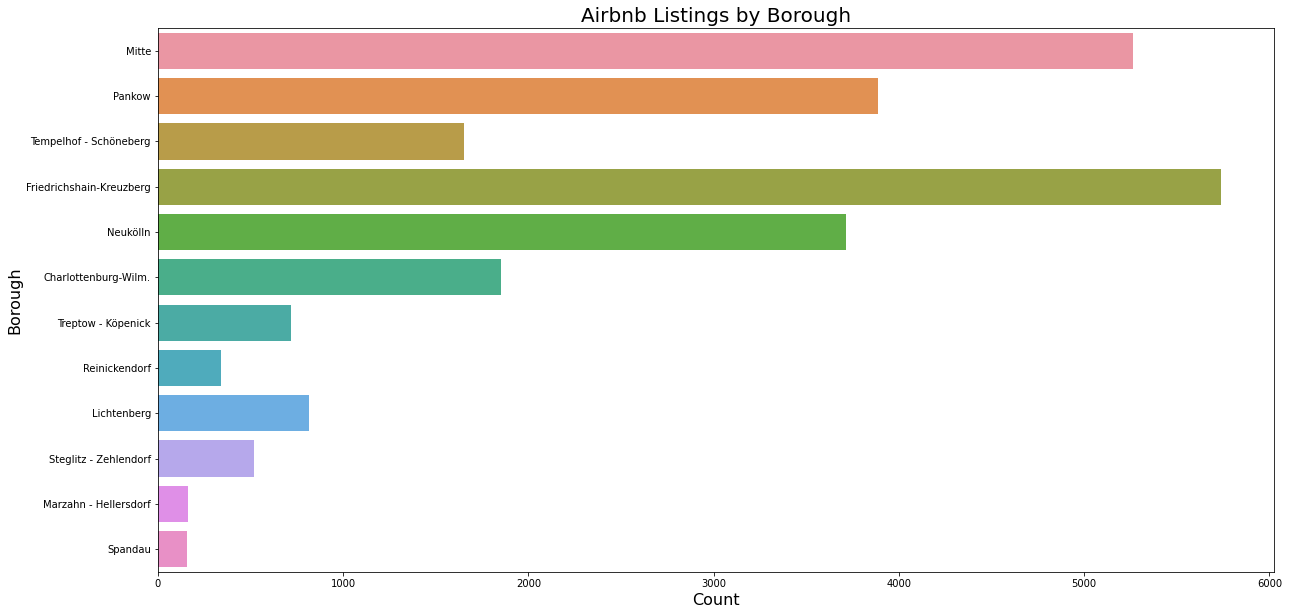

In [25]:
plt.figure(figsize=(20,10));sns.countplot(y=listings['borough']);plt.title('Airbnb Listings by Borough',fontsize=20);plt.ylabel('Borough',fontsize=16);plt.xlabel('Count',fontsize=16);
plt.savefig('Airbnb_plotcount.png')

Mitte, Pankow, Kreuzberg, and Neukolln clearly have the highest number of Airbnbs. Mitte sits in the middle of the city near tourist sites and a lot of hotels so it's large value makes sense.
The other three boroughs are trendy neighborhoods which are all at the core of the housing problem in Berlin.
Friedrichshain-kreuzberg which used to be a slum, is now the trendy nightlife capital of Europe. Some similarities can be drawn between kreuzberg and the Lower East Side in Manhattan.
Many people and businesses have had to move out of kreuzberg to formerly more expensive boroughsin order to escape the rising rents.
This simple count plot shows how kreuzberg is at the center of the problem.
The 5 lowest boroughs are on the outskirts of Berlin and away from any tourist attractions.

listings.to_csv(r"C:\Users\Alex Cerce\JupyterNB\BerlinAirbnb\listingsdf.csv",encoding='utf-8',index=False)
#exporting dataframe to make geo visualizations in a seperate enviroment due to package issue

As seen on the choropleth maps, there are three nieghborhoods with a high number of Airbnbs which stand out

In [26]:
#plt.figure(figsize=(40,20));sns.countplot(y='neighborhood',hue='borough',data=listings,order=pd.value_counts(listings['neighborhood']).iloc[:20].index);plt.title('Airbnb Listings by Neighborhood',fontsize=20);plt.ylabel('Neighborhood',fontsize=16);plt.xlabel('Count',fontsize=16);

#make a count plot by neighborhood with a color to indicate which borough it belongs to
#I want the bar to be centered and look nice which means I need to take the longer and custom Matplotlib route


neighborhood_count=listings[['neighborhood','borough']];neighborhood_count['count']=1;
neighborhood_count=neighborhood_count.groupby(by=['neighborhood','borough']).count().sort_values(by=['count'],ascending=False)
neighborhood_countsel=neighborhood_count.iloc[:15]
#plt.figure(figsize=(40,20));#plt.barh(neighborhood_countsel.index.get_level_values(0).values,neighborhood_countsel['count'].values,color=neighborhood_countsel.index.get_level_values(1).values)
print('Top 15 Neighborhoods with the most Airbnbs:');print(neighborhood_countsel)






Top 15 Neighborhoods with the most Airbnbs:
                                                   count
neighborhood             borough                        
Frankfurter Allee Süd FK Friedrichshain-Kreuzberg   1435
Tempelhofer Vorstadt     Friedrichshain-Kreuzberg   1312
Alexanderplatz           Mitte                      1257
Reuterstraße             Neukölln                   1058
Rixdorf                  Neukölln                    908
Brunnenstr. Süd          Mitte                       894
Neuköllner Mitte/Zentrum Neukölln                    839
Frankfurter Allee Nord   Friedrichshain-Kreuzberg    724
Prenzlauer Berg Nordwest Pankow                      698
südliche Luisenstadt     Friedrichshain-Kreuzberg    688
Schillerpromenade        Neukölln                    685
Prenzlauer Berg Südwest  Pankow                      658
Prenzlauer Berg Süd      Pankow                      603
Wedding Zentrum          Mitte                       594
Schöneberg-Nord          Tempelhof - Schöneb

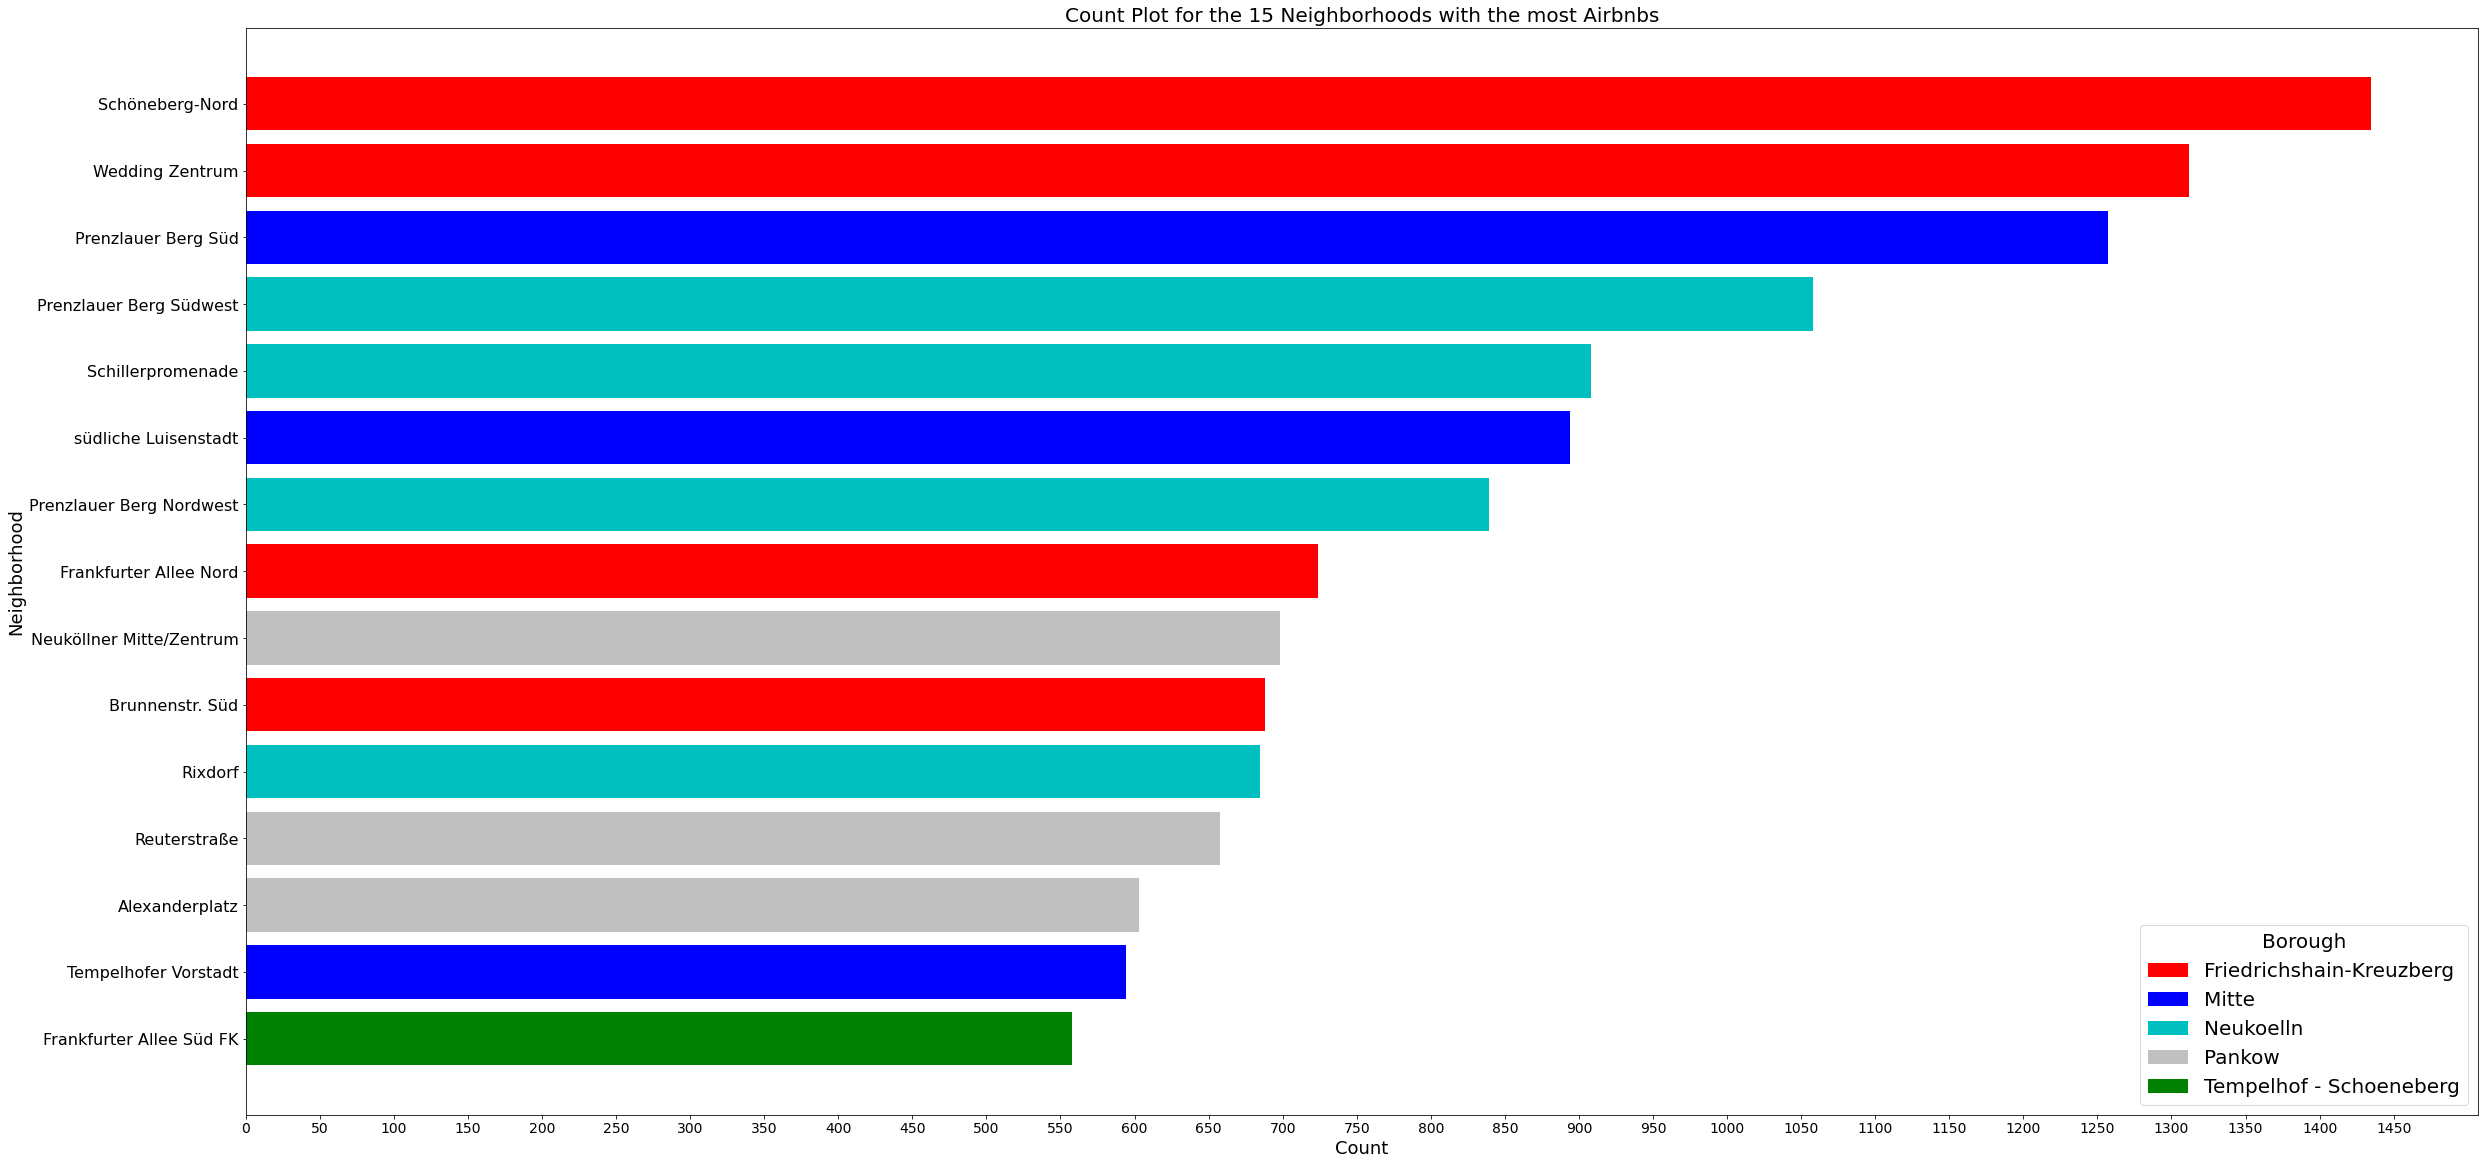

In [27]:
#since there isn't a very good way to do this, I will be hard coding it just to get this visualization
#This isn't ideal, but I consider this to be okay in this situation since this is just to make a visualization 
plt.figure(figsize=(40,20))
N=np.arange(len(neighborhood_countsel.index.get_level_values(0).values))

#Friedrichshain-kreuzberg
countvar=tuple(reversed((1435,1312,0,0,0,0,0,724,0,688,0,0,0,0,0)))
plt.barh(N,countvar,label='Friedrichshain-Kreuzberg',color='r')
#Mite
countvar=tuple(reversed((0,0,1257,0,0,894,0,0,0,0,0,0,0,594,0)))
plt.barh(N,countvar,label='Mitte',color='b')
#Neukolln
countvar=tuple(reversed((0,0,0,1058,908,0,839,0,0,0,685,0,0,0,0)))
plt.barh(N,countvar,label='Neukoelln',color='c')
#Pankow
countvar=tuple(reversed((0,0,0,0,0,0,0,0,698,0,0,658,603,0,0)))
plt.barh(N,countvar,label='Pankow',color='silver')
#Tempelhof-Schoneberg
countvar=tuple(reversed((0,0,0,0,0,0,0,0,0,0,0,0,0,0,558)))
plt.barh(N,countvar,label='Tempelhof - Schoeneberg',color='g')

plt.yticks(N, ('Frankfurter Allee Süd FK', 'Tempelhofer Vorstadt', 'Alexanderplatz', 'Reuterstraße', 'Rixdorf','Brunnenstr. Süd','Neuköllner Mitte/Zentrum','Frankfurter Allee Nord','Prenzlauer Berg Nordwest','südliche Luisenstadt','Schillerpromenade','Prenzlauer Berg Südwest','Prenzlauer Berg Süd','Wedding Zentrum','Schöneberg-Nord'),fontsize=16)
plt.xticks(np.arange(0, 1500, 50),fontsize=14)
plt.title('Count Plot for the 15 Neighborhoods with the most Airbnbs',fontsize=20)
plt.xlabel('Count',fontsize=18)
plt.ylabel('Neighborhood',fontsize=18)
plt.legend(loc='lower right',prop={'size': 20},title='Borough',title_fontsize=20)
plt.show();

In [28]:
listings['accommodates'].unique()

array([ 3,  4,  1,  2,  7,  5,  8,  6, 14, 12,  9, 10, 16, 11, 15, 13, 24,
        0], dtype=int64)

c:\users\alex cerce\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\alex cerce\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


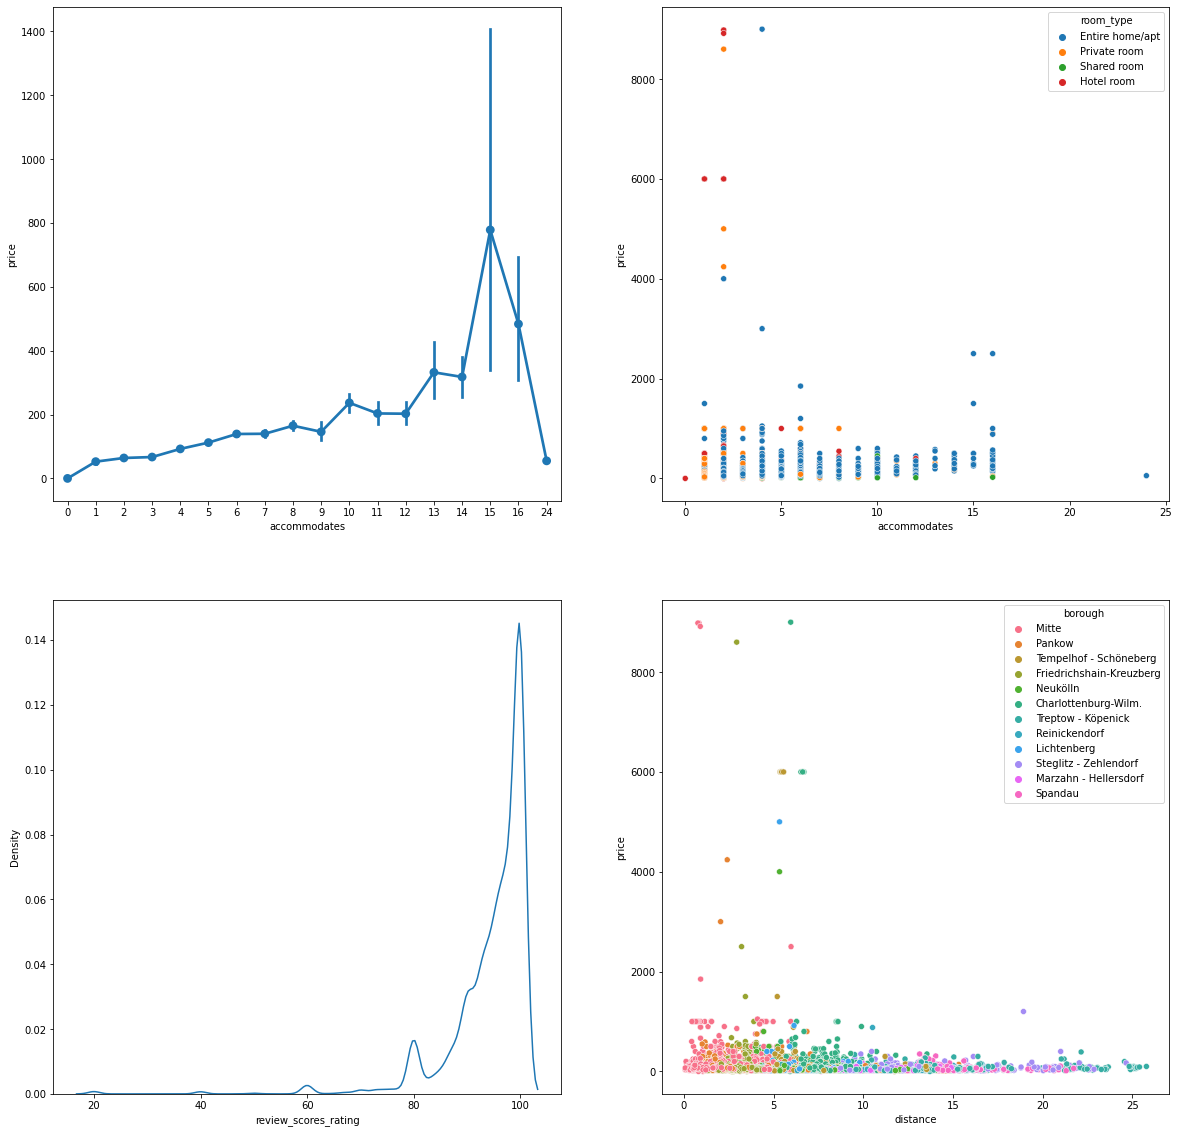

<Figure size 432x288 with 0 Axes>

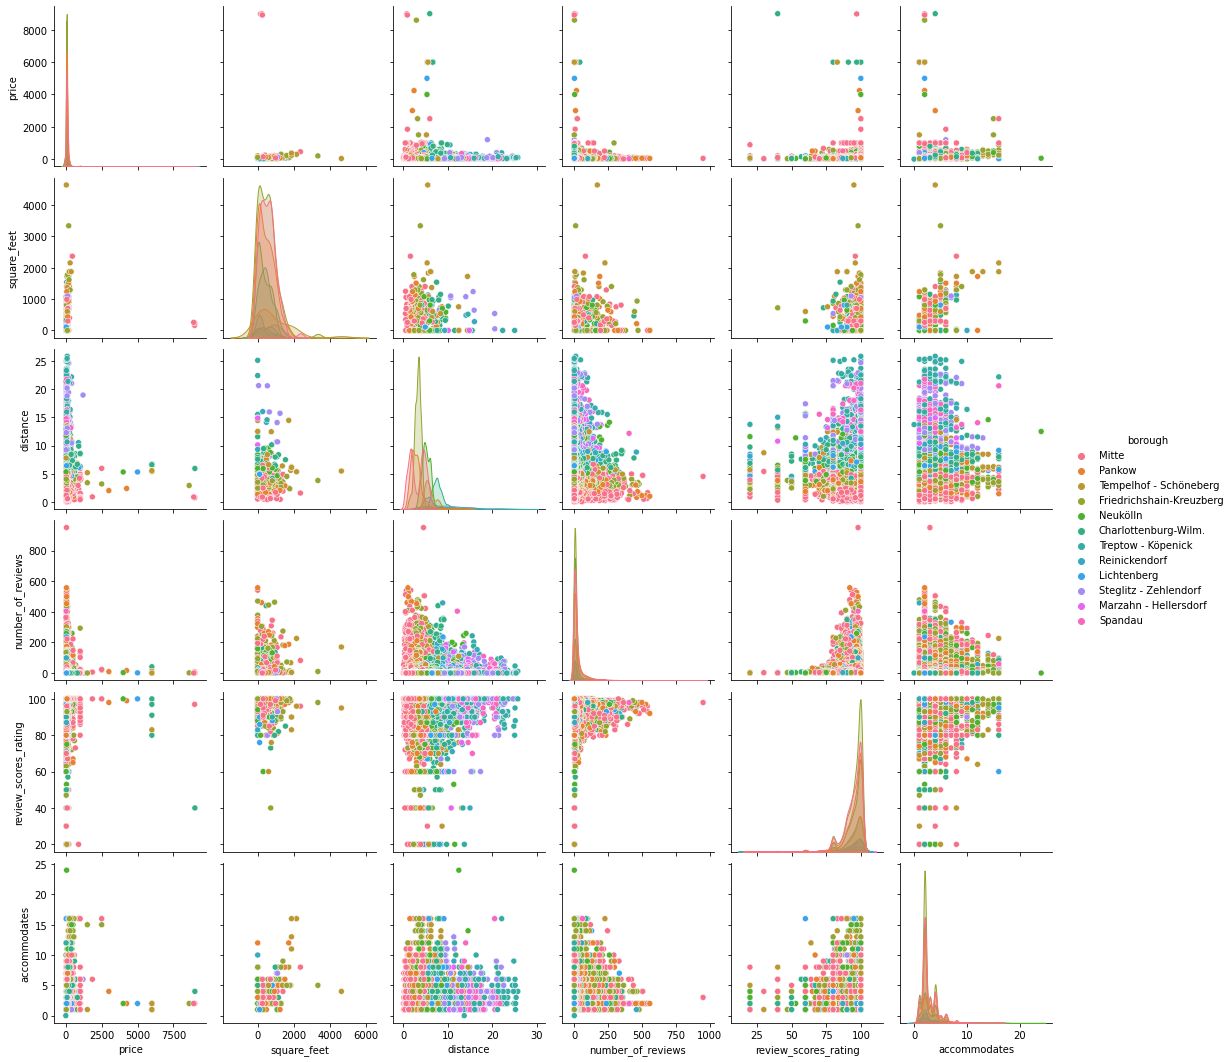

In [29]:
fig,ax=plt.subplots(2,2,figsize=(20,20));sns.pointplot(ax=ax[0,0],data=listings,y='price',x='accommodates');
sns.scatterplot(data=listings,y='price',x='accommodates',hue='room_type',ax=ax[0,1]);
sns.scatterplot(data=listings,x='distance',y='price',hue='borough',ax=ax[1,1]);

sns.kdeplot(data=listings,x='review_scores_rating',ax=ax[1,0]);
#As the accommodation number for an Airbnb rises, price splowly increases.
#For higher accommodation levels there is more uncertainty in price. This is because of lower amount of listings
plt.figure();sns.pairplot(listings[['price','square_feet','distance','number_of_reviews','review_scores_rating','accommodates','borough']],hue='borough');

In [30]:
listings.columns

Index(['listing_id', 'host_id', 'neighborhood', 'borough', 'latitude',
       'longitude', 'room_type', 'price', 'square_feet', 'number_of_reviews',
       'reviews_per_month', 'review_scores_rating', 'host_is_superhost',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'calculated_host_listings_count', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_365', 'distance'],
      dtype='object')

Percentage Distribution of Room Types:
Entire home/apt    51.868
Private room       45.928
Shared room         1.237
Hotel room          0.967
Name: room_type, dtype: float64
--------------------------------------------------
Percentage Distribution of Square Feet
NaN       98.392
0.0        0.411
646.0      0.052
753.0      0.048
807.0      0.044
           ...  
50.0       0.004
1539.0     0.004
1098.0     0.004
33.0       0.004
620.0      0.004
Name: square_feet, Length: 107, dtype: float64

Distribution of Square Feet in Bins
(-4.640000000000001, 463.9]    0.858
(463.9, 927.8]                 0.496
(927.8, 1391.7]                0.173
(1391.7, 1855.6]               0.052
(1855.6, 2319.5]               0.016
(2319.5, 2783.4]               0.004
(3247.3, 3711.2]               0.004
(4175.1, 4639.0]               0.004
(2783.4, 3247.3]               0.000
(3711.2, 4175.1]               0.000
Name: square_feet, dtype: float64
--------------------------------------------------


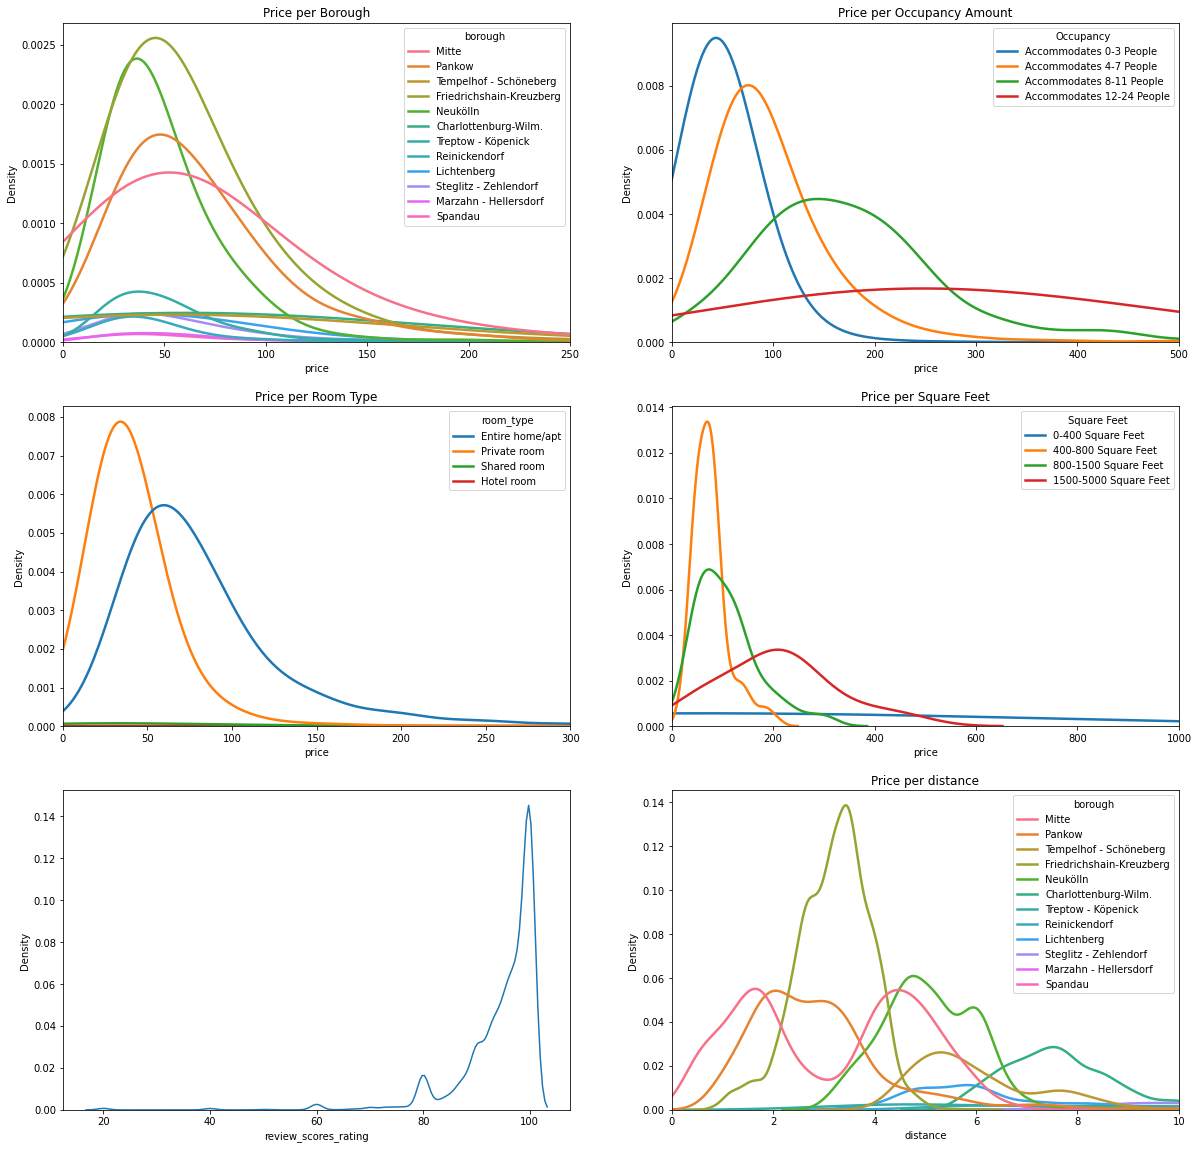

In [31]:
fig,ax=plt.subplots(3,2,figsize=(20,20))
sns.kdeplot(data=listings, x='price', hue='borough', shade=False, clip=(0, 250), linewidth=2.5, ax=ax[0,0])
ax[0,0].set_xlim(0,250)
ax[0,0].set_title('Price per Borough')
sns.kdeplot(data=listings.query('accommodates<4'), x='price', shade=False, clip=(0,500), linewidth=2.5, label='Accommodates 0-3 People', ax=ax[0,1])
sns.kdeplot(data=listings.query('accommodates>=4 & accommodates<8'), x='price', shade=False, clip=(0,500), linewidth=2.5, label='Accommodates 4-7 People', ax=ax[0,1])
sns.kdeplot(data=listings.query('accommodates>=8 & accommodates<12'), x='price', shade=False, clip=(0,500), linewidth=2.5, label='Accommodates 8-11 People', ax=ax[0,1])
sns.kdeplot(data=listings.query('accommodates>=12'), x='price', shade=False, clip=(0,500), linewidth=2.5, label='Accommodates 12-24 People', ax=ax[0,1])
ax[0,1].set_xlim(0,500)
ax[0,1].set_title('Price per Occupancy Amount');
ax[0,1].legend(loc='upper right',title='Occupancy')
sns.kdeplot(data=listings, x='price', hue='room_type', clip=(0,300), linewidth=2.5, ax=ax[1,0])
ax[1,0].set_xlim(0,300)
ax[1,0].set_title('Price per Room Type')
sns.kdeplot(data=listings.query('square_feet<400 & square_feet>5'), x='price', shade=False, clip=(0,1000), linewidth=2.5, label='0-400 Square Feet', ax=ax[1,1])
sns.kdeplot(data=listings.query('square_feet>=400 & square_feet<800'), x='price', shade=False, clip=(0,1000), linewidth=2.5, label='400-800 Square Feet', ax=ax[1,1])
sns.kdeplot(data=listings.query('square_feet>=800 & square_feet<1500'), x='price', shade=False, clip=(0,1000), linewidth=2.5, label='800-1500 Square Feet', ax=ax[1,1])
sns.kdeplot(data=listings.query('square_feet>=1500'), x='price', shade=False, clip=(0,1000), linewidth=2.5, label='1500-5000 Square Feet', ax=ax[1,1])
ax[1,1].legend(loc='upper right',title='Square Feet')
ax[1,1].set_xlim(0,1000)
ax[1,1].set_title('Price per Square Feet')

sns.kdeplot(data=listings,x='distance',hue='borough',clip=(0,10),linewidth=2.5,ax=ax[2,1]);
ax[2,1].set_xlim(0,10);
ax[2,1].set_title('Price per distance')
sns.kdeplot(data=listings,x='review_scores_rating',ax=ax[2,0]);

print('Percentage Distribution of Room Types:')
print(round(listings['room_type'].value_counts(normalize=True)*100,3))
print('-'*50)
print('Percentage Distribution of Square Feet')
print(round(listings['square_feet'].value_counts(normalize=True,dropna=False)*100,3))
print('');print('Distribution of Square Feet in Bins')
print(round(listings['square_feet'].value_counts(normalize=True,bins=10)*100,3))
print('-'*50)

# Visualizations

# Pricing
* use xgboost regressor to find the the optimal listing price for a new Airbnb

### Prepare Training Set:
* Encode categorical variables
* train/test split
* cv splits

In [32]:
#create a new dataframe for these predictions which is different than the one used for visualizations
listings_prediction=listings
listings_prediction.columns

Index(['listing_id', 'host_id', 'neighborhood', 'borough', 'latitude',
       'longitude', 'room_type', 'price', 'square_feet', 'number_of_reviews',
       'reviews_per_month', 'review_scores_rating', 'host_is_superhost',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'calculated_host_listings_count', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_365', 'distance'],
      dtype='object')

In [33]:
# Removing unneeded variables
listings_prediction.drop(['listing_id','host_id','square_feet','latitude','longitude','number_of_reviews','reviews_per_month','review_scores_rating'],axis=1,inplace=True)
#Since I will not be using the calendar table, listing_id and host_id won't be very useful
#Remove square feet since the majority of it's values are missing
#I will remove Latitude/Longitude and keep distance
#finally, I will remove the features that deal with reviews. This is because the new Airbnb will have no review information to provide

In [34]:
#A few columns contain missing a small amount of missing values. XGBoost has support for missing values.
#Therefore, I will make these missing values zero so that they work with XGBoost

'''From above we found:
'square_feet' has 24414 missing values
'reviews_per_month' has 4670 missing values
'review_scores_rating' has 5167 missing values
'bathrooms' has 20 missing values
'bedrooms' has 42 missing values
'beds' has 222 missing values''';
listings_prediction.fillna(0,inplace=True)

In [35]:
#Encode categorical variables
listings['host_is_superhost']=listings['host_is_superhost']*1    #Convert Boolean into integer values. 1 signifies True, 0 is false
listings_prediction=pd.get_dummies(listings_prediction, prefix=['neighborhood', 'borough', 'room_type']);

In [56]:
#Train/Test Split
listings_prediction=listings_prediction.sample(frac=1,random_state=random_state); #shuffle dataset before split
X=listings_prediction.drop('price',axis=1);y=listings_prediction['price'];
fold=KFold(n_splits=10,random_state=random_state);
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=random_state);

In [61]:
XGB=XGBRegressor(random_state=random_state)
XGB_Parameters={'classification__max_depth':[2,3,4,5,6,7,8,9,10],'classification__learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3],'classification__n_estimators':[100,200,250,300,350,400,500]};
XGB_grid = RandomizedSearchCV(estimator = XGB, param_distributions=XGB_Parameters, scoring='neg_mean_absolute_error', cv=fold, n_jobs=-1, n_iter=15,return_train_score=True,random_state=random_state);
XGB_grid.fit(Xtrain, ytrain);
XGB_Estimator=XGB_grid.best_estimator_;
XGB_bestscore=XGB_grid.best_score_;

scoring = {'r2','neg_mean_absolute_error','neg_root_mean_squared_error'}
scores_XGB = cross_validate(XGB_Estimator, Xtrain, ytrain, scoring=scoring, cv=fold, return_train_score=True, n_jobs=-1)
XGB_r2=scores_XGB['test_r2']
XGB_MAE=scores_XGB['test_neg_mean_absolute_error']
XGB_RMSE=scores_XGB['test_neg_root_mean_squared_error']

print('R2: %0.3f with a standard deviation of %0.3f' % (XGB_r2.mean(), XGB_r2.std()));
print('MAE: %0.3f with a standard deviation of %0.3f' % (XGB_MAE.mean(), XGB_MAE.std()));
print('RMSE: %0.3f with a standard deviation of %0.3f' % (XGB_RMSE.mean(), XGB_RMSE.std()));
print(XGB_bestscore)

[17:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { classification__learning_rate, classification__max_depth, classification__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


R2: 0.525 with a standard deviation of 0.329
MAE: -26.465 with a standard deviation of 2.183
RMSE: -120.654 with a standard deviation of 67.782
-26.46488530931905


In [62]:
#test set
XGB_prediction=XGB_Estimator.predict(Xtest)
print('Test Score:')
XGB_r2_test=r2_score(ytest,XGB_prediction)
XGB_MAE_test=mean_absolute_error(ytest,XGB_prediction)
XGB_RMSE_test=mean_squared_error(ytest,XGB_prediction,squared=False)
print('R2: %0.3f with a standard deviation of %0.3f' % (XGB_r2_test.mean(), XGB_r2_test.std()));
print('MAE: %0.3f with a standard deviation of %0.3f' % (XGB_MAE_test.mean(), XGB_MAE_test.std()));
print('RMSE: %0.3f with a standard deviation of %0.3f' % (XGB_RMSE_test.mean(), XGB_RMSE_test.std()));

Test Score:
R2: 0.601 with a standard deviation of 0.000
MAE: 29.469 with a standard deviation of 0.000
RMSE: 172.950 with a standard deviation of 0.000


Text(0.5, 0, 'Importance')

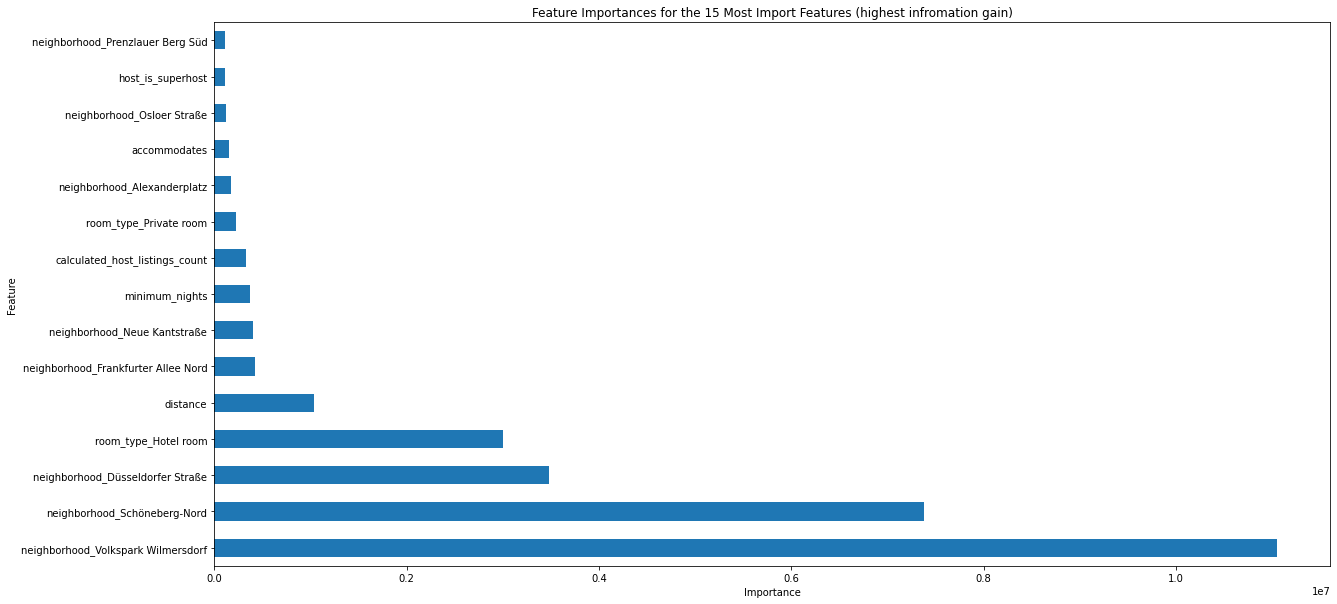

In [105]:
d=XGB_Estimator.get_booster().get_score(importance_type="gain");
sorted_d = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True));

Importances=pd.DataFrame(sorted_d,index=[0]).transpose();
Importances=Importances.rename(columns={0 : "Importance"});
Importances.iloc[:15].plot.barh(figsize=(20,10),legend=False);
plt.title('Feature Importances for the 15 Most Import Features (highest infromation gain)')
plt.ylabel('Feature');plt.xlabel('Importance')

In [106]:
Importances.head(20)

,Importance
neighborhood_Volkspark Wilmersdorf,1.105333e+07
neighborhood_Schöneberg-Nord,7.379355e+06
neighborhood_Düsseldorfer Straße,3.482701e+06
room_type_Hotel room,3.000870e+06
distance,1.034823e+06
neighborhood_Frankfurter Allee Nord,4.179399e+05
neighborhood_Neue Kantstraße,4.036803e+05
minimum_nights,3.697605e+05
calculated_host_listings_count,3.268282e+05
room_type_Private room,2.231744e+05


### 